In [ ]:
import os
import torch

distributions = torch.load(
    "/cluster/project/krause/frankem/chemflow/data/qm9/processed/distributions.pt"
)
distributions.keys()

dict_keys(['atom_type_distribution', 'edge_type_distribution', 'charge_type_distribution', 'n_atoms_distribution', 'coordinate_std'])

In [4]:
n_atoms_dist = distributions["n_atoms_distribution"]
print(len(n_atoms_dist))
n_atoms_dist

30


tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4972e-05, 2.9944e-05, 3.7430e-05,
        8.9832e-05, 1.5721e-04, 5.0156e-04, 1.3699e-03, 3.8403e-03, 8.4667e-03,
        1.7390e-02, 3.1748e-02, 5.2979e-02, 7.9337e-02, 1.0644e-01, 1.2988e-01,
        1.3324e-01, 1.3714e-01, 9.4317e-02, 9.8733e-02, 3.3560e-02, 4.7626e-02,
        5.3375e-03, 1.4396e-02, 4.4168e-04, 2.6650e-03, 0.0000e+00, 2.6201e-04])

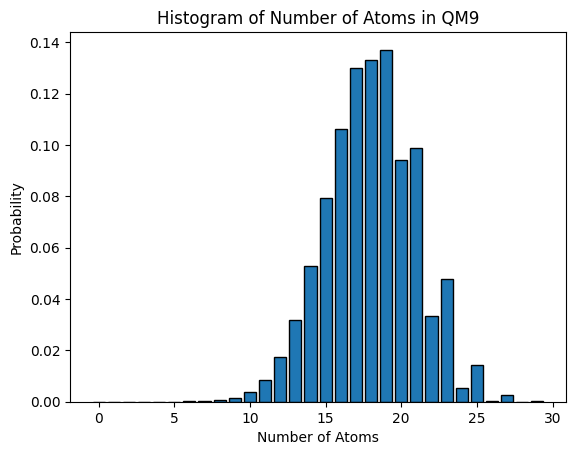

In [ ]:
# visualize n_atoms_dist as a histogram
import matplotlib.pyplot as plt

counts = list(range(len(n_atoms_dist)))
probs = n_atoms_dist

plt.bar(counts, probs, edgecolor="black")
plt.xlabel("Number of Atoms")
plt.ylabel("Probability")
plt.title("Histogram of Number of Atoms in QM9")
plt.show()


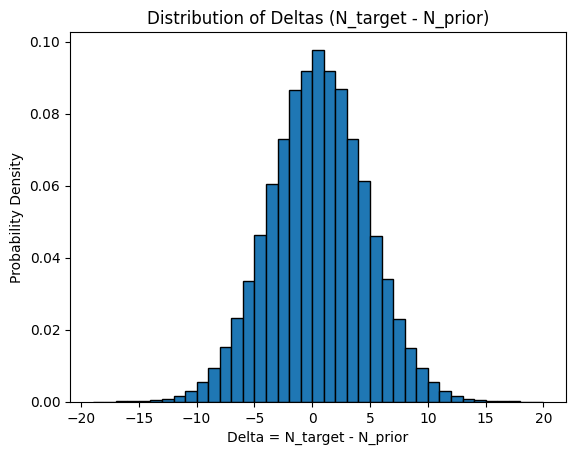

--- Poisson Suitability Check (Random Pairing) ---
Average Insertions Needed: 3.66
Variance of Insertions:    5.87
Dispersion Ratio:          1.60
------------------------------
Verdict: 🔴 USE NEGATIVE BINOMIAL (Ratio 1.60)
Reason:  High variance. You are pairing random small graphs
         with random large graphs. The 'need' fluctuates wildly.


In [ ]:
import torch
import matplotlib.pyplot as plt


def check_poisson_random_pair(probs, min_size):
    """
    Checks if Poisson is suitable when Prior and Target are
    sampled independently from the SAME distribution.

    Args:
        probs (Tensor): Probability of each size bin.
        min_size (int): The starting size corresponding to probs[0].
    """
    # 1. Setup the distribution
    support = torch.arange(len(probs)) + min_size

    # 2. Monte Carlo Simulation (Sample 500,000 pairs)
    num_samples = 500000

    indices_prior = torch.multinomial(probs, num_samples, replacement=True)
    indices_target = torch.multinomial(probs, num_samples, replacement=True)

    N_prior = support[indices_prior]
    N_target = support[indices_target]

    # 3. Calculate deltas (Target - Prior)
    delta = N_target - N_prior

    # Plot: Distribution of deltas
    fig, ax = plt.subplots()
    delta_np = delta.numpy()
    # Use bins covering all possible deltas (negative up to positive)
    bins = range(int(delta.min().item()), int(delta.max().item()) + 2)
    ax.hist(delta_np, bins=bins, edgecolor="black", density=True)
    ax.set_xlabel("Delta = N_target - N_prior")
    ax.set_ylabel("Probability Density")
    ax.set_title("Distribution of Deltas (N_target - N_prior)")
    plt.show()

    # Filter: Only cases where insertions > 0
    insertions_needed = delta[delta > 0].float()

    if len(insertions_needed) == 0:
        print("Distributions are identical delta-functions. No insertions ever needed.")
        return

    # 4. Calculate Stats
    mean = torch.mean(insertions_needed)
    variance = torch.var(insertions_needed)
    ratio = variance / mean

    # 5. Report
    print(f"--- Poisson Suitability Check (Random Pairing) ---")
    print(f"Average Insertions Needed: {mean:.2f}")
    print(f"Variance of Insertions:    {variance:.2f}")
    print(f"Dispersion Ratio:          {ratio:.2f}")
    print("-" * 30)

    if ratio > 1.2:
        print(f"Verdict: 🔴 USE NEGATIVE BINOMIAL (Ratio {ratio:.2f})")
        print("Reason:  High variance. You are pairing random small graphs")
        print("         with random large graphs. The 'need' fluctuates wildly.")
    else:
        print(f"Verdict: 🟢 POISSON IS OK (Ratio {ratio:.2f})")
        print("Reason:  Variance is constrained. Your graph sizes are likely")
        print("         very concentrated.")


# --- Example Usage ---
# tensor_probs = torch.tensor([0.1, 0.2, 0.4, 0.2, 0.1]) # Bell curve-ish
# check_poisson_random_pair(tensor_probs, min_size=10)

check_poisson_random_pair(n_atoms_dist, min_size=0)

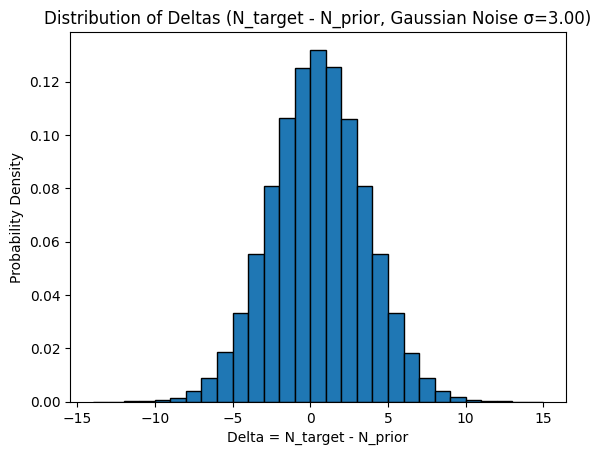

--- Poisson Suitability Check (Gaussian Prior, sigma=3.0) ---
Average Insertions Needed: 2.75
Variance of Insertions:    2.95
Dispersion Ratio:          1.07
------------------------------
Verdict: 🟢 POISSON IS OK (Ratio 1.07)
Reason:  With sigma=3.0, the noise is tight enough.


In [ ]:
import torch
import matplotlib.pyplot as plt


def check_poisson_gaussian_prior(probs, min_size, sigma):
    """
    Checks dispersion when Prior = Target + GaussianNoise.

    Args:
        probs (Tensor): Probability of each size bin in the training set.
        min_size (int): The starting size corresponding to probs[0].
        sigma (float): The std deviation of your Gaussian noise (e.g., 5.0).
    """
    num_samples = 500000

    # 1. Sample Targets from the Data Distribution
    # (We still need this to respect the domain boundaries, e.g., min_size)
    support = torch.arange(len(probs)) + min_size
    indices_target = torch.multinomial(probs, num_samples, replacement=True)
    N_target = support[indices_target].float()

    # 2. Sample Prior relative to Target
    # N_prior ~ Normal(N_target, sigma)
    noise = torch.randn(num_samples) * sigma

    # Round to nearest integer to simulate discrete graph sizes
    N_prior = torch.round(N_target + noise)

    # 3. Calculate Insertions Needed
    # Delta = Target - Prior.
    # Since Prior = Target + Noise, Delta = -Noise.
    delta = N_target - N_prior

    # --- Plot: Distribution of deltas ---
    fig, ax = plt.subplots()
    delta_np = delta.numpy()
    bins = range(int(delta.min().item()), int(delta.max().item()) + 2)
    ax.hist(delta_np, bins=bins, edgecolor="black", density=True)
    ax.set_xlabel("Delta = N_target - N_prior")
    ax.set_ylabel("Probability Density")
    ax.set_title(
        "Distribution of Deltas (N_target - N_prior, Gaussian Noise σ=%.2f)" % sigma
    )
    plt.show()

    # Filter: We only care about cases where we need to ADD nodes (delta > 0).
    # This effectively creates a "Half-Normal" distribution of insertions.
    insertions_needed = delta[delta > 0]

    if len(insertions_needed) == 0:
        print("Sigma is too small (or zero). No insertions ever generated.")
        return

    # 4. Calculate Stats
    mean = torch.mean(insertions_needed)
    variance = torch.var(insertions_needed)
    ratio = variance / mean

    # 5. Report
    print(f"--- Poisson Suitability Check (Gaussian Prior, sigma={sigma}) ---")
    print(f"Average Insertions Needed: {mean:.2f}")
    print(f"Variance of Insertions:    {variance:.2f}")
    print(f"Dispersion Ratio:          {ratio:.2f}")
    print("-" * 30)

    # Thresholds are slightly different here because Half-Normal distributions
    # are naturally under-dispersed for small sigmas.
    if ratio > 1.2:
        print(f"Verdict: 🔴 USE NEGATIVE BINOMIAL (Ratio {ratio:.2f})")
        print(f"Reason:  With sigma={sigma}, the spread of necessary edits is")
        print("         too wide for a pure Poisson to handle stably.")
    else:
        print(f"Verdict: 🟢 POISSON IS OK (Ratio {ratio:.2f})")
        print(f"Reason:  With sigma={sigma}, the noise is tight enough.")


# --- Example Usage ---
# tensor_probs = torch.tensor([0.1, 0.2, 0.4, 0.2, 0.1])
# check_poisson_gaussian_prior(tensor_probs, min_size=10, sigma=5.0)

check_poisson_gaussian_prior(n_atoms_dist, min_size=0, sigma=3.0)